# Transfer learning with TensorFlow Hub

## Setup

In [15]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## An ImageNet classifier

We will start by using a classifier model pre-trained on the ImageNet benchmark dataset -no initial training is required!

### Download the classifier

We will select a InceptionV3 pre-trained model from TensorFlow Hub and wrap it as a Keras layer with `hub.KerasLayer`.

In [16]:
inception_v3_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

IMAGE_SHAPE = (224, 224)

classifer = tf.keras.Sequential([
    hub.KerasLayer(inception_v3_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

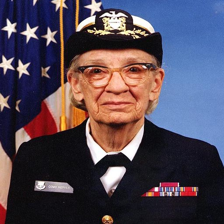

In [17]:
# Downloading a single image
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [18]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [19]:
# Add a batch dimension and pass the image to the model
result = classifer.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 716ms/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

In [20]:
# The top class ID can be found with tf.math.argmax
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=458>

### Decode the predictions

In [21]:
# Fetch the ImageNet dataset labels to decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

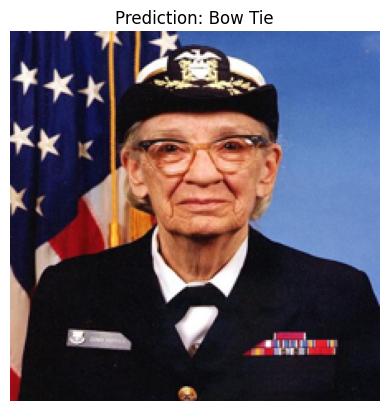

In [22]:
# Take the predicted class label
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title('Prediction: ' + predicted_class_name.title());

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset?

To do that, you can:
1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, we will use the TensorFlow flowers dataset.

In [23]:
import pathlib

data_file = tf.keras.utils.get_file(
    'flower_photos.tgz',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    cache_dir='.',
    extract=True
)

data_root = pathlib.Path(data_file).with_suffix('')

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`.

In [24]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


The flowers dataset have five classes:

In [25]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achive this.

In [26]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x-images, y-labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x-images, y-labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefecth`, so you can yield the data from disk without I/O blocking issues.

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images

In [29]:
result_batch = classifer.predict(train_ds)

92/92 [==============================] - 7s 70ms/step


In [30]:
predicted_class_name = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_name

array(['daisy', 'cauliflower', 'rapeseed', ..., 'daisy', 'daisy',
       'cardoon'], dtype='<U30')

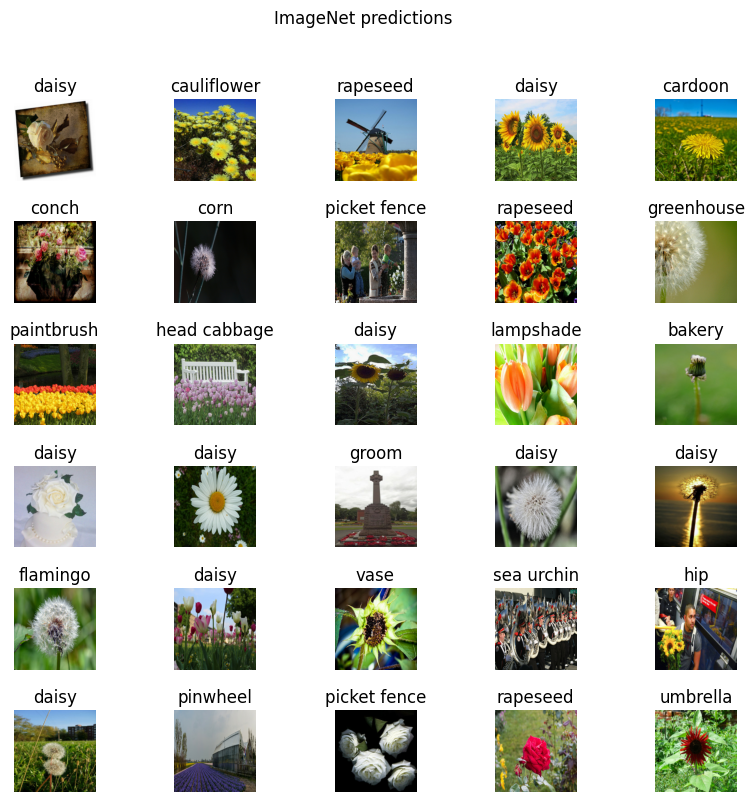

In [31]:
# Check how this predictions line up with the images:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_name[n])
    plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for.

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a InceptionV3 pre-trained model from TensorFlow Hub. Any compatible image feature vector model from TensorFlow Hub will work here.

In [33]:
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model_url = inception_v3

Create the feature extractor by wrapping the pre-trained model as a Keras layer with `hub.KerasLayer`. Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [34]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model_url,
    input_shape=(224, 224, 3),
    trainable=False
)

In [35]:
# The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [36]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [37]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

### Train the model

In [39]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

Add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [ ]:
log_dir = 'logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1 # Enable histogram computation for every epoch.
)

To visualize the training progress in TensorBoard later, create and store logs and a TensorBoard callback.

In [41]:
# Fit the model
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
92/92 [==============================] - 15s 127ms/step - loss: 0.7553 - acc: 0.7275 - val_loss: 0.4507 - val_acc: 0.8515
Epoch 2/10
92/92 [==============================] - 9s 101ms/step - loss: 0.4153 - acc: 0.8532 - val_loss: 0.3924 - val_acc: 0.8665
Epoch 3/10
92/92 [==============================] - 10s 105ms/step - loss: 0.3329 - acc: 0.8873 - val_loss: 0.3748 - val_acc: 0.8665
Epoch 4/10
92/92 [==============================] - 9s 102ms/step - loss: 0.2806 - acc: 0.9084 - val_loss: 0.3674 - val_acc: 0.8665
Epoch 5/10
92/92 [==============================] - 9s 102ms/step - loss: 0.2429 - acc: 0.9213 - val_loss: 0.3628 - val_acc: 0.8692
Epoch 6/10
92/92 [==============================] - 10s 104ms/step - loss: 0.2140 - acc: 0.9322 - val_loss: 0.3602 - val_acc: 0.8719
Epoch 7/10
92/92 [==============================] - 10s 103ms/step - loss: 0.1913 - acc: 0.9428 - val_loss: 0.3599 - val_acc: 0.8733
Epoch 8/10
92/92 [==============================] - 9s 102ms/step - loss

### Check the predictions

In [43]:
# Obtain the ordered list of class names from the model predictions
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 481ms/step
['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


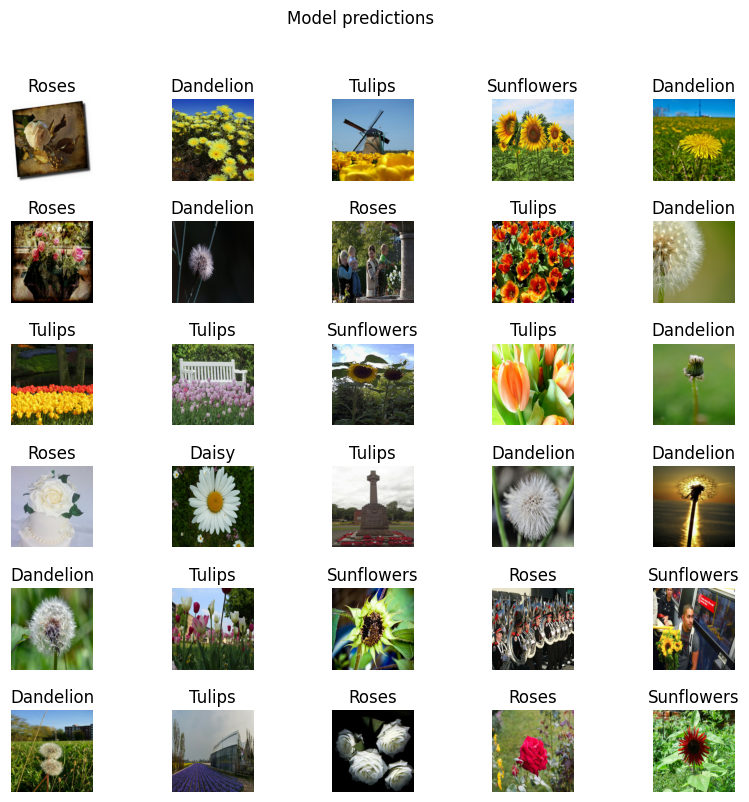

In [44]:
# Plot the model predictions
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
plt.suptitle('Model predictions');

### Export and reload your model

In [45]:
# Export the trained model
t = time.time()

export_path = '/tmp/saved_models/{}'.format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1752257818\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1752257818\assets


'/tmp/saved_models/1752257818'

In [46]:
# Reload the model
reloaded = tf.keras.models.load_model(export_path)

In [47]:
# Confirm that the model is able to output the same results
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

1/1 [==============================] - 0s 466ms/step


0.0

In [48]:
# Predictions with the reloaded model
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


Text(0.5, 0.98, 'Model prediction')

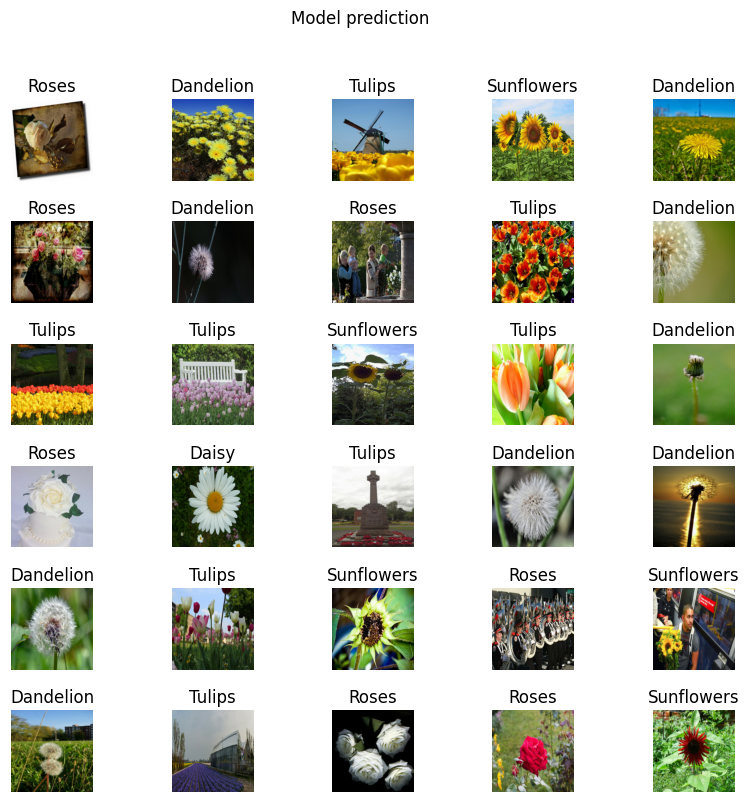

In [49]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(reloaded_predicted_label_batch[n].title())
    plt.axis('off')
plt.suptitle('Model prediction')